<a href="https://colab.research.google.com/github/gabbosanti/machine-learning-assignment/blob/main/assignement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CRISP-DM analysis of second-half goal scoring in football

This notebook contains all the code of the assignement.The detailed description can be found in the related paper.
The workflow follows the CRISP-DM pattern.

# Business Understanding

The business goal of this project is to understand whether events occurring in the first half of a football match can be used to predict if the home team will score at least one goal in the second half.

This type of prediction could be interesting in real-world applications such as live match analysis or betting systems.

However, football matches are highly unpredictable and influenced by many external factors (tactical changes, injuries, red cards, psychological aspects) that are not present in the dataset.

For this reason, the goal of this assignment is not to achieve high predictive accuracy, but to evaluate the feasibility and limits of machine learning models in this context.

# Data Understanding

For the analysis in our system, many free available datasets are available.
Kaggle is one of the most famous online platforms that contains lot of free available dataset.
One of the most complete and general-purporse is availabile here : https://www.kaggle.com/datasets/secareanualin/football-events
It's actually composed of :

*   events.csv
*   ginf.csv
*   dictionary.txt

Considering the huge number of events, it's a good idea to store them in a \data folder

In [ ]:
import kagglehub
import os, shutil
from pathlib import Path

path = kagglehub.dataset_download("secareanualin/football-events")
print("Kaggle dataset path:", path)

work_dir = Path("data")
work_dir.mkdir(exist_ok=True) #create a new directory

#moving csv files in data path
for fname in ["events.csv", "ginf.csv", "dictionary.txt"]:
    shutil.copy(Path(path) / fname, work_dir / fname)

events_path = work_dir / "events.csv"
ginf_path   = work_dir / "ginf.csv"


Using Colab cache for faster access to the 'football-events' dataset.
Kaggle dataset path: /kaggle/input/football-events


Stores the datasets in a Pandas dataframe.

In [ ]:
import pandas as pd

events_df = pd.read_csv(events_path)
ginf_df   = pd.read_csv(ginf_path)


events.csv

In [ ]:
events_df

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0
1,UFot0hit/,UFot0hit2,2,4,"Corner, Borussia Dortmund. Conceded by Dennis...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
2,UFot0hit/,UFot0hit3,3,4,"Corner, Borussia Dortmund. Conceded by Heiko ...",2,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
3,UFot0hit/,UFot0hit4,4,7,Foul by Sven Bender (Borussia Dortmund).,3,NaN,1,Borussia Dortmund,Hamburg SV,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
4,UFot0hit/,UFot0hit5,5,7,Gokhan Tore (Hamburg) wins a free kick in the ...,8,NaN,2,Hamburg SV,Borussia Dortmund,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941004,z5L2OT5E/,z5L2OT5E123,123,92,Lucas Torreira (Sampdoria) wins a free kick in...,8,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,2.0,NaN,0,NaN,0
941005,z5L2OT5E/,z5L2OT5E124,124,93,"Corner, Sampdoria. Conceded by Andrea Masiello.",2,NaN,2,Sampdoria,Atalanta,...,NaN,NaN,NaN,NaN,0,NaN,NaN,0,NaN,0
941006,z5L2OT5E/,z5L2OT5E125,125,93,Attempt missed. Fabio Quagliarella (Sampdoria)...,1,12.0,2,Sampdoria,Atalanta,...,NaN,NaN,8.0,2.0,0,9.0,1.0,1,3.0,0
941007,z5L2OT5E/,z5L2OT5E126,126,94,Alberto Grassi (Atalanta) wins a free kick on ...,8,NaN,1,Atalanta,Sampdoria,...,NaN,NaN,NaN,NaN,0,4.0,NaN,0,NaN,0


ginf.csv

In [ ]:
ginf_df

,id_odsp,link_odsp,adv_stats,date,league,season,country,ht,at,fthg,ftag,odd_h,odd_d,odd_a,odd_over,odd_under,odd_bts,odd_bts_n
0,UFot0hit/,/soccer/germany/bundesliga-2011-2012/dortmund-...,True,2011-08-05,D1,2012,germany,Borussia Dortmund,Hamburg SV,3,1,1.56,4.41,7.42,NaN,NaN,NaN,NaN
1,Aw5DflLH/,/soccer/germany/bundesliga-2011-2012/augsburg-...,True,2011-08-06,D1,2012,germany,FC Augsburg,SC Freiburg,2,2,2.36,3.60,3.40,NaN,NaN,NaN,NaN
2,bkjpaC6n/,/soccer/germany/bundesliga-2011-2012/werder-br...,True,2011-08-06,D1,2012,germany,Werder Bremen,Kaiserslautern,2,0,1.83,4.20,4.80,NaN,NaN,NaN,NaN
3,CzPV312a/,/soccer/france/ligue-1-2011-2012/paris-sg-lori...,True,2011-08-06,F1,2012,france,Paris Saint-Germain,Lorient,0,1,1.55,4.50,9.40,NaN,NaN,NaN,NaN
4,GUOdmtII/,/soccer/france/ligue-1-2011-2012/caen-valencie...,True,2011-08-06,F1,2012,france,Caen,Valenciennes,1,0,2.50,3.40,3.45,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10107,xAkY8l6R/,/soccer/italy/serie-a/genoa-crotone-xAkY8l6R/,True,2017-01-22,I1,2017,italy,Genoa,Crotone,2,2,1.97,4.35,8.00,1.95,2.03,2.03,1.86
10108,xSU9scI9/,/soccer/england/premier-league/chelsea-hull-ci...,True,2017-01-22,E0,2017,england,Chelsea,Hull,2,0,1.19,8.50,20.00,1.54,2.68,2.40,1.66
10109,xY7uZwOI/,/soccer/france/ligue-1/monaco-lorient-xY7uZwOI/,True,2017-01-22,F1,2017,france,AS Monaco,Lorient,4,0,1.32,6.24,11.50,1.53,3.08,1.80,2.25
10110,YyeGxMX8/,/soccer/spain/laliga/betis-gijon-YyeGxMX8/,True,2017-01-22,SP1,2017,spain,Real Betis,Sporting Gijon,0,0,1.74,4.07,5.90,2.20,1.89,2.05,1.86


### Data Profiling

Once collecting data, it's important to describe their statistics

In [ ]:
events_summary = pd.DataFrame({
    "dtype": events_df.dtypes,
    "non_null_count": events_df.notna().sum(),
    "null_count": events_df.isna().sum(),
    "unique_values": events_df.nunique()
})

events_summary


,dtype,non_null_count,null_count,unique_values
id_odsp,object,941009,0,9074
id_event,object,941009,0,941009
sort_order,int64,941009,0,180
time,int64,941009,0,101
text,object,941009,0,366076
event_type,int64,941009,0,11
event_type2,float64,214293,726716,4
side,int64,941009,0,2
event_team,object,941009,0,142
opponent,object,941009,0,142


We note the huge amount of data, but concerning important features, none of them is missing

In [ ]:
ginf_df_summary = pd.DataFrame({
    "dtype": ginf_df.dtypes,
    "non_null_count": ginf_df.notna().sum(),
    "null_count": ginf_df.isna().sum(),
    "unique_values": ginf_df.nunique()
})

ginf_df_summary

,dtype,non_null_count,null_count,unique_values
id_odsp,object,10112,0,10112
link_odsp,object,10112,0,10112
adv_stats,bool,10112,0,2
date,object,10112,0,967
league,object,10112,0,5
season,int64,10112,0,6
country,object,10112,0,5
ht,object,10112,0,147
at,object,10112,0,148
fthg,int64,10112,0,11


It's important to notice that some game in ginf_df are empty of events so must be excluded from the analysis.


# Data Preparation



Creating the aggregate dataset, merging the two above
Only first-half events were considered in order to avoid any information leakage from the second half.

In [ ]:
def create_dataset():

    # Reduce events_df dataset, filtering only first-half events
    first_half_events = events_df[events_df['time'] <= 45].copy()

    #Discarding useless features
    first_half_events = first_half_events.drop(columns=['sort_order' , 'time', 'text' , 'event_team' , 'opponent', 'player' , 'player2' , 'player_in' , 'player_out' , 'shot_place', 'location' , 'bodypart' , 'assist_method' , 'situation', 'fast_break'])

    #Extracting only matches with events
    matches_with_events = first_half_events['id_odsp'].unique()
    ginf_filtered = ginf_df[ginf_df['id_odsp'].isin(matches_with_events)].copy()

    # Creating new features from dictionary.txt
    first_half_events['shot_on_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 1)
    ).astype(int)

    first_half_events['shot_off_target'] = (
      (first_half_events['event_type'] == 1) &
      (first_half_events['shot_outcome'] == 2)
    ).astype(int)

    first_half_events['corner'] = (first_half_events['event_type'] == 2).astype(int)
    first_half_events['free_kick'] = (first_half_events['event_type'] == 8).astype(int)
    first_half_events['offside'] = (first_half_events['event_type'] == 9).astype(int)
    first_half_events['foul'] = (first_half_events['event_type'] == 3).astype(int)
    first_half_events['yellow_card'] = (first_half_events['event_type'] == 4).astype(int)
    first_half_events['goal'] = first_half_events['is_goal'].astype(int)

    # Aggregation : calculating how many occurences of every event
    matches_features = (first_half_events.groupby(['id_odsp', 'side'] , as_index=False).agg({
            'shot_on_target': 'sum',
            'shot_off_target': 'sum',
            'corner': 'sum',
            'free_kick': 'sum',
            'offside': 'sum',
            'foul': 'sum',
            'yellow_card': 'sum',
            'goal': 'sum'
        })
    )

    #Renaming in home and away
    home = matches_features[matches_features['side'] == 1].drop(columns='side').add_suffix('_home')
    away = matches_features[matches_features['side'] == 2].drop(columns='side').add_suffix('_away')

    #Renaming columns for merging
    home = home.rename(columns={'id_odsp_home': 'id_odsp'})
    away = away.rename(columns={'id_odsp_away': 'id_odsp'})

    #Merging to ginf_ds
    dataset = (
        ginf_filtered[['id_odsp', 'fthg']]
        .merge(home, on='id_odsp', how='left')
        .merge(away, on='id_odsp', how='left')
    )

    #Creating target
    dataset['home_scored_second_half'] = (
        (dataset['fthg'] - dataset['goal_home']) > 0
    ).astype(int)

    dataset = dataset.drop(columns=['fthg'])
    return pd.DataFrame(dataset)


In [ ]:
df = create_dataset()
df

,id_odsp,shot_on_target_home,shot_off_target_home,corner_home,free_kick_home,offside_home,foul_home,yellow_card_home,goal_home,shot_on_target_away,shot_off_target_away,corner_away,free_kick_away,offside_away,foul_away,yellow_card_away,goal_away,home_scored_second_half
0,UFot0hit/,3,5,4,5,1,5,0,2,0,2,2,5,0,6,1,0,1
1,Aw5DflLH/,3,3,2,15,0,8,2,0,1,1,2,9,0,15,1,0,1
2,bkjpaC6n/,2,2,2,15,3,5,0,0,1,0,2,7,4,15,1,0,1
3,CzPV312a/,0,3,2,5,3,10,1,0,2,1,2,11,4,4,1,1,0
4,GUOdmtII/,1,5,1,6,1,6,0,1,4,3,5,6,1,6,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9069,xAkY8l6R/,1,0,2,3,3,9,0,1,2,2,5,9,1,3,1,0,1
9070,xSU9scI9/,2,1,7,7,1,6,1,1,2,1,2,6,0,7,2,0,1
9071,xY7uZwOI/,6,5,3,7,2,4,0,3,0,0,1,4,0,7,1,0,1
9072,YyeGxMX8/,3,4,6,6,4,4,0,0,1,2,4,4,1,5,1,0,0


In [ ]:
df.describe()

,shot_on_target_home,shot_off_target_home,corner_home,free_kick_home,offside_home,foul_home,yellow_card_home,goal_home,shot_on_target_away,shot_off_target_away,corner_away,free_kick_away,offside_away,foul_away,yellow_card_away,goal_away,home_scored_second_half
count,9074.00000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000
mean,2.15076,2.658585,2.705863,6.381530,1.250496,6.075270,0.709830,0.688010,1.688561,2.095217,2.060062,6.208287,1.129711,6.242341,0.859048,0.496033,0.566343
std,1.58661,1.706320,1.857598,2.599145,1.235859,2.564662,0.834146,0.840252,1.371478,1.486622,1.589682,2.592674,1.180237,2.572997,0.882913,0.710361,0.495606
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.00000,1.000000,1.000000,5.000000,0.000000,4.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,0.000000,0.000000
50%,2.00000,2.000000,2.000000,6.000000,1.000000,6.000000,1.000000,0.000000,1.000000,2.000000,2.000000,6.000000,1.000000,6.000000,1.000000,0.000000,1.000000
75%,3.00000,4.000000,4.000000,8.000000,2.000000,8.000000,1.000000,1.000000,2.000000,3.000000,3.000000,8.000000,2.000000,8.000000,1.000000,1.000000,1.000000
max,11.00000,12.000000,12.000000,17.000000,9.000000,17.000000,5.000000,6.000000,9.000000,11.000000,11.000000,17.000000,8.000000,17.000000,6.000000,5.000000,1.000000


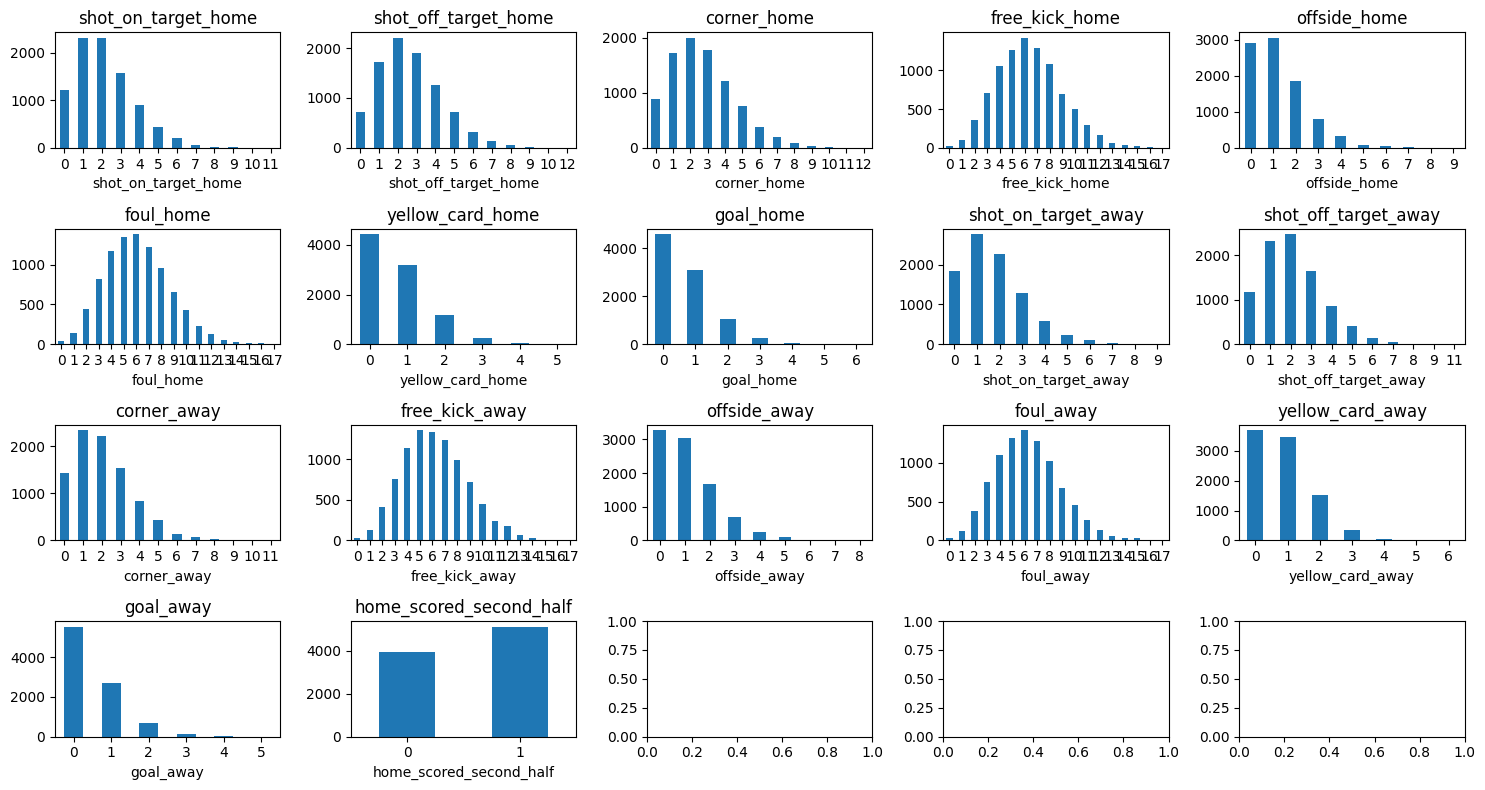

In [ ]:
import math
import matplotlib.pyplot as plt

cols = df.columns.drop("id_odsp")

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 8))
axes = axes.ravel() #semplify access to each subplot

for i, col in enumerate(cols):
    df[col].value_counts().sort_index().plot(
        kind='bar', #bar histogram
        ax=axes[i], #in the right subplot
        rot=0,
        title=col
    )

fig.tight_layout()
plt.show()


## Correlation Matrix

<Axes: >

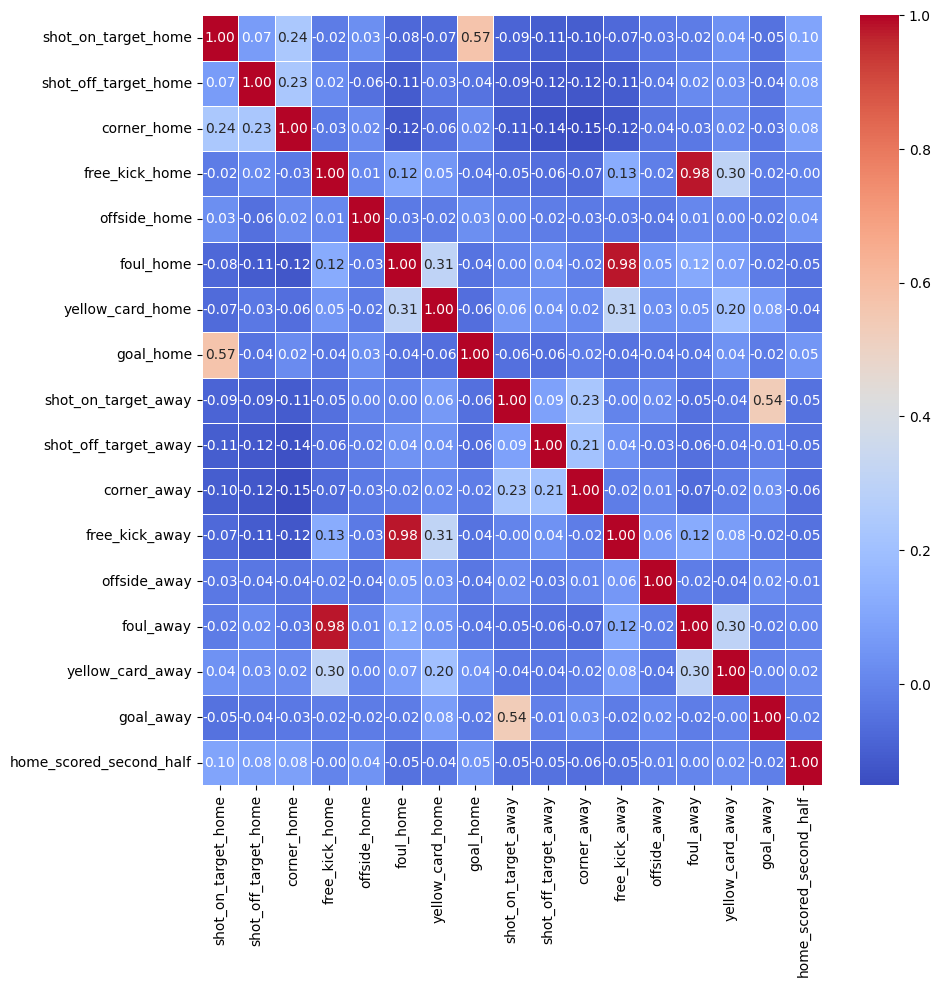

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

correlation_data = df.drop("id_odsp", axis="columns").corr() #creating a dataframe with correlation
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

The plot shows that, although the dataset is very rich in terms of events, many of them are weakly correlated with actual goal scoring, especially when considering only first-half information.

# Modeling

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X = df.drop(["home_scored_second_half", "id_odsp"], axis="columns")
y = df["home_scored_second_half"]

seed=42 #Set a random seed for ensuring reproducibility
split=0.20 # 20% of the dataset is for test, remaining 80% for training the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=seed)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (7259, 16)
y_train: (7259,)
X_test: (1815, 16)
y_test: (1815,)


Printing metrics for each model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

result_list = []

def print_metrics(model_name, y_true, y_pred):

    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
    }

    result_list.append(metrics)

    print(f"\n{model_name}")
    for key, value in metrics.items():
        if key != "Model":
            print(f"{key}: {value}")

    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))



## Decision Tree

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
seed = 42 #set a random seed

def train_decision_tree(X_train, y_train):
    #Define the hyperparameter space
    hyperparameter_space = {
        'criterion': ['gini', 'entropy'], #impurity index
        'splitter': ['best', 'random'],
        'max_depth': [2, 3, 4, 5],
        'min_samples_split': [10, 20], #before split
        'min_samples_leaf': [5, 10], #after split
        'max_features': ['sqrt', 'log2']
    }
    clf = DecisionTreeClassifier(random_state=seed)

    random_search = RandomizedSearchCV( #Randomize search on hyperparameters
        estimator=clf,
        param_distributions=hyperparameter_space,
        n_iter=50,
        cv=5, #k-fold cross validation (k =5)
        scoring='accuracy',
        random_state=seed,
    )

    random_search.fit(X_train, y_train)

    best_dt_clf = random_search.best_estimator_ #return the best decision-tree
    cv_score = random_search.best_score_ #return the cross-validation score

    return best_dt_clf, cv_score

best_dt_clf, cv_score = train_decision_tree(X_train, y_train)

print("Best decision tree : ", best_dt_clf)
print("CV score:", cv_score)

y_pred = best_dt_clf.predict(X_test)

print_metrics("Decision Tree", y_test, y_pred)


Best decision tree :  DecisionTreeClassifier(max_depth=5, max_features='log2', min_samples_leaf=10,
                       min_samples_split=20, random_state=42)
CV score: 0.5701886985891746

Decision Tree
Accuracy: 0.5669421487603306
Precision: 0.57125
Recall: 0.9013806706114399
Confusion Matrix:
 [[115 686]
 [100 914]]


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

def train_random_forest(X_train, y_train):

    param_grid_rf = {
        'n_estimators': [100, 200, 300], #number of trees
        'max_depth': [2, 5, 8, 12],
        'min_samples_split': [2, 5, 10, 20], #before split
        'min_samples_leaf': [1, 2, 5, 10], #after split
        'max_features': ['sqrt', 'log2']
    }

    rf_clf = RandomForestClassifier(random_state=seed)

    random_search_rf = RandomizedSearchCV(
        estimator=rf_clf,
        param_distributions=param_grid_rf,
        n_iter=50,
        cv=5,
        scoring='accuracy',
        random_state=seed,
    )

    random_search_rf.fit(X_train, y_train)

    best_rf_clf = random_search_rf.best_estimator_
    cv_score = random_search_rf.best_score_

    return best_rf_clf, cv_score

best_rf_clf, cv_score = train_random_forest(X_train, y_train)

print("Best Random Forest:", best_rf_clf)
print("CV score:", cv_score)

y_pred = best_rf_clf.predict(X_test)

print_metrics("Random Forest", y_test, y_pred)

Best Random Forest: RandomForestClassifier(max_depth=12, max_features='log2', min_samples_leaf=10,
                       random_state=42)
CV score: 0.5779027667819097

Random Forest
Accuracy: 0.5829201101928375
Precision: 0.5899230230930721
Recall: 0.8313609467455622
Confusion Matrix:
 [[215 586]
 [171 843]]


## AutoML


In [ ]:
!pip install flaml
from flaml import AutoML
from sklearn.metrics import accuracy_score

automl = AutoML()
automl.fit(X_train,
           y_train,
           task="classification",
           time_budget=60
)

y_pred = automl.predict(X_test)
print("Best model found by AutoML:", automl.model)

print_metrics("AutoML", y_test, y_pred)

[flaml.automl.logger: 01-26 09:03:23] {2375} INFO - task = classification
[flaml.automl.logger: 01-26 09:03:23] {2386} INFO - Evaluation method: cv
[flaml.automl.logger: 01-26 09:03:23] {2489} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 01-26 09:03:23] {2606} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 01-26 09:03:23] {2911} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 01-26 09:03:23] {3046} INFO - Estimated sufficient time budget=1538s. Estimated necessary time budget=36s.
[flaml.automl.logger: 01-26 09:03:23] {3097} INFO -  at 0.2s,	estimator lgbm's best error=4.2993e-01,	best estimator lgbm's best error=4.2993e-01
[flaml.automl.logger: 01-26 09:03:23] {2911} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 01-26 09:03:23] {3097} INFO -  at 0.3s,	estimator lgbm's best error=4.2993e-01,	best estimator lgbm's best error=4.2993e-01
[flaml.autom

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 01-26 09:03:24] {3097} INFO -  at 0.7s,	estimator sgd's best error=4.1998e-01,	best estimator sgd's best error=4.1998e-01
[flaml.automl.logger: 01-26 09:03:24] {2911} INFO - iteration 4, current learner lgbm
[flaml.automl.logger: 01-26 09:03:24] {3097} INFO -  at 0.8s,	estimator lgbm's best error=4.2600e-01,	best estimator sgd's best error=4.1998e-01
[flaml.automl.logger: 01-26 09:03:24] {2911} INFO - iteration 5, current learner sgd
[flaml.automl.logger: 01-26 09:03:24] {3097} INFO -  at 1.0s,	estimator sgd's best error=4.1693e-01,	best estimator sgd's best error=4.1693e-01
[flaml.automl.logger: 01-26 09:03:24] {2911} INFO - iteration 6, current learner sgd
[flaml.automl.logger: 01-26 09:03:24] {3097} INFO -  at 1.2s,	estimator sgd's best error=4.1693e-01,	best estimator sgd's best error=4.1693e-01
[flaml.automl.logger: 01-26 09:03:24] {2911} INFO - iteration 7, current learner lgbm
[flaml.automl.logger: 01-26 09:03:24] {3097} INFO -  at 1.3s,	estimator lgbm's be

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 01-26 09:04:22] {3097} INFO -  at 59.0s,	estimator lrl1's best error=4.1701e-01,	best estimator rf's best error=4.1219e-01
[flaml.automl.logger: 01-26 09:04:22] {2911} INFO - iteration 148, current learner lrl1
[flaml.automl.logger: 01-26 09:04:23] {3097} INFO -  at 59.5s,	estimator lrl1's best error=4.1680e-01,	best estimator rf's best error=4.1219e-01
[flaml.automl.logger: 01-26 09:04:23] {2911} INFO - iteration 149, current learner xgboost
[flaml.automl.logger: 01-26 09:04:24] {3097} INFO -  at 60.4s,	estimator xgboost's best error=4.1633e-01,	best estimator rf's best error=4.1219e-01
[flaml.automl.logger: 01-26 09:04:25] {3359} INFO - retrain rf for 1.3s
[flaml.automl.logger: 01-26 09:04:25] {3362} INFO - retrained model: RandomForestClassifier(criterion=np.str_('gini'),
                       max_features=np.float64(0.376374973175452),
                       max_leaf_nodes=38, n_estimators=134, n_jobs=-1,
                       random_state=12032022)
[flaml.a

# Evaluation

## Creating a dataframe that summarize metrics of each model

In [ ]:
df_results = pd.DataFrame(result_list)
df_results



,Model,Accuracy,Precision,Recall
0,Decision Tree,0.566942,0.571250,0.901381
1,Random Forest,0.582920,0.589923,0.831361
2,AutoML,0.576860,0.579870,0.880671


Accuracy alone is not sufficient to fully evaluate model performance, especially in a potentially imbalanced classification problem.
For this reason, precision and recall were also considered to better understand the model behavior.

All models achieved similar performance, with no clear winner.
Even AutoML, which automatically selects and tunes models, was not able to significantly outperform the manually tuned approaches.

# Conclusion


This project shows that predicting football outcomes using only first-half match events is a very challenging task.
Despite using different models and hyperparameter tuning strategies, the overall performance remains limited.

This should not be interpreted as a failure of the models, but rather as a consequence of the intrinsic unpredictability of football matches and the limited information available in the dataset.

In this sense, the assignment highlights an important aspect of machine learning: model performance is strongly dependent on data quality and problem formulation.